# RNNで太宰治風の文章生成

## 準備

### ライブラリのインポート

In [2]:
import time, math, random, pickle
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
print(torch.__version__)
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F

1.4.0


### GPUを利用する

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## データの読み込み

### 学習済み単語ベクトル(chiVeより作成)をロード

In [0]:
filename = './data/emb_layer_50k.npy'
with open(filename, 'rb') as f:
  emb_layer = np.load(f)
  unk_vec = np.sum(emb_layer, axis=0) / len(emb_layer)

  emb_layer = np.append(emb_layer, unk_vec.reshape(1, -1), axis=0)
  embeddings = torch.tensor(emb_layer, dtype=torch.float, device=device)

### 単語と単語IDを変換する辞書をロード

In [0]:
filename = './data/word2id_50k.pkl'
with open(filename, 'rb') as f:
  word_to_id = pickle.load(f)
  id_to_word = {v: k for k, v in word_to_id.items()}

  dict_len = len(word_to_id)
  word_to_id['<unk>'] = dict_len
  id_to_word[dict_len] = '<unk>'

### コーパスをロード

In [0]:
corpus = np.array([], dtype=int)

corpus_dir = Path('./data/corpus')
for file_path in corpus_dir.glob('*.npy'):
  if not file_path.exists():
    print(file_path + ' does not exist!')
    continue
  with open(file_path, 'rb') as f:
    corpus = np.concatenate((corpus, np.load(f)))

print(len(corpus))

1385480


## 入力データの整形

### 訓練データ、検証データ、テストデータに分割

In [0]:
train_ratio = 0.8
val_ratio = 0.1

size = len(corpus)
train_size = math.floor(size * train_ratio)
val_size = math.floor(size * val_ratio)

train = torch.tensor(corpus[:train_size], dtype=torch.long, device=device)
val = torch.tensor(corpus[train_size:train_size + val_size],
                   dtype=torch.long, device=device)
test = torch.tensor(corpus[train_size + val_size:],
                    dtype=torch.long, device=device)
print(len(train), len(val), len(test))

1108384 138548 138548


### ミニバッチ化

In [0]:
class MyBPTTIterator(object):
  """Return given data in the shape of (seq_len, batch_size)"""

  def __init__(self, data, batch_size, bptt_len):
    nbatch = data.size(0) // batch_size
    data = data.narrow(0, 0, nbatch * batch_size)
    self.data = data.view(batch_size, -1).t().contiguous()
    self.batch_size = batch_size
    self.bptt_len = bptt_len

  @classmethod
  def splits(cls, datasets, batch_size, bptt_len):
    ret = []
    for data in datasets:
      ret.append(cls(data, batch_size, bptt_len))
    return tuple(ret)

  def __len__(self):
    return math.ceil((len(self.data) - 1 ) / self.bptt_len)
  
  def __iter__(self):
    for i in range(0, len(self.data) - 1, self.bptt_len):
      seq_len = min(self.bptt_len, len(self.data) - 1 - i)
      text = self.data[i:i + seq_len]
      target = self.data[i + 1:i + 1 + seq_len]
      yield text, target


batch_size = 20
bptt_len = 35

train_iter, val_iter, test_iter = MyBPTTIterator.splits(
    (train, val, test), batch_size, bptt_len)
print(len(train_iter), len(val_iter), len(test_iter))

1584 198 198


## モデルの構築

In [0]:
class MyLSTM(nn.Module):
  def __init__(self, vocab_size, emb_dim, hidden_size, dropout=0.5,
               embeddings=None, freeze=False, weight_tied=False):
    super(MyLSTM, self).__init__()

    if embeddings is not None:
      weight_size = (vocab_size, emb_dim)
      if embeddings.size() != weight_size:
        raise ValueError(
            f'Expected weight size {weight_size}, got {embeddings.size()}')
      self.embed = nn.Embedding.from_pretrained(embeddings, freeze=freeze)
    else:
      self.embed = nn.Embedding(vocab_size, emb_dim)
    self.dropout1 = nn.Dropout(dropout)
    self.lstm1 = nn.LSTM(emb_dim, hidden_size)
    self.dropout2 = nn.Dropout(dropout)
    self.lstm2 = nn.LSTM(hidden_size, emb_dim)
    self.dropout3 = nn.Dropout(dropout)
    self.linear = nn.Linear(emb_dim, vocab_size)

    nn.init.normal_(self.embed.weight, std=0.01)
    nn.init.normal_(self.lstm1.weight_ih_l0, std=1/math.sqrt(emb_dim))
    nn.init.normal_(self.lstm1.weight_hh_l0, std=1/math.sqrt(hidden_size))
    nn.init.zeros_(self.lstm1.bias_ih_l0)
    nn.init.zeros_(self.lstm1.bias_hh_l0)
    nn.init.normal_(self.lstm2.weight_ih_l0, std=1/math.sqrt(hidden_size))
    nn.init.normal_(self.lstm2.weight_hh_l0, std=1/math.sqrt(hidden_size))
    nn.init.zeros_(self.lstm2.bias_ih_l0)
    nn.init.zeros_(self.lstm2.bias_hh_l0)
    if weight_tied:
      self.linear.weight = self.embed.weight
    else:
      nn.init.normal_(self.linear.weight, std=1/math.sqrt(emb_dim))
    nn.init.zeros_(self.linear.bias)

  def forward(self, input, hidden_prev):
    if hidden_prev is None:
      hidden1_prev, hidden2_prev = None, None
    else:
      hidden1_prev = hidden_prev[0:2]
      hidden2_prev = hidden_prev[2:4]
    
    emb_out = self.embed(input)
    emb_out = self.dropout1(emb_out)
    lstm1_out, hidden1_next = self.lstm1(emb_out, hidden1_prev)
    lstm1_out = self.dropout2(lstm1_out)
    lstm2_out, hidden2_next = self.lstm2(lstm1_out, hidden2_prev)
    lstm2_out = self.dropout3(lstm2_out)
    output = self.linear(lstm2_out)

    hidden_next = hidden1_next + hidden2_next
    return output, hidden_next

### パープレキシティを評価する関数

In [0]:
def eval_perplexity(model, iterator):
  total_loss = 0
  hidden = None

  model.eval()
  with torch.no_grad():
    for input, target in iterator:
      output, hidden = model(input, hidden)
      loss = F.cross_entropy(output.view(-1, vocab_size), target.view(-1))
      total_loss += loss.item()
  
  ppl = math.exp(total_loss / len(iterator))
  return ppl

## モデルの学習



### 学習準備

In [0]:
vocab_size = len(word_to_id)
emb_dim = embeddings.size()[1]
print(vocab_size, emb_dim)

hidden_size = emb_dim
dropout = 0.5
learning_rate = 20.0

model = MyLSTM(vocab_size, emb_dim, hidden_size, dropout,
               embeddings, freeze=False, weight_tied=True)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

50001 300


### 学習の実行

In [0]:
max_epoch = 30
max_norm = 0.25

total_loss, loss_count = 0, 0
ppl_list = []
best_ppl = float('inf')
save_path = './data/model/weights.pth'

for epoch in range(max_epoch):
  model.train()
  hidden = None
  start = time.time()

  for i, iters in enumerate(train_iter):
    input, target = iters
    optimizer.zero_grad()
    output, hidden = model(input, hidden)
    loss = criterion(output.view(-1, vocab_size), target.view(-1))
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
    optimizer.step()
    hidden = tuple(h.detach() for h in hidden)

    total_loss += loss.item()
    loss_count += 1
    if i % 500 == 0:
      ppl = math.exp(total_loss / loss_count)
      ppl_list.append(ppl)
      total_loss, loss_count = 0, 0
      if epoch == 0 and i == 0:
        print(f'initial ppl : {ppl:.2f}')

  val_ppl = eval_perplexity(model, val_iter)
  t = time.time() - start
  print(f'| epoch {epoch+1} : valid perplexity {val_ppl:.2f}  time {t:.2f}s |')
  if val_ppl < best_ppl:
    best_ppl = val_ppl
    torch.save(model.state_dict(), save_path)
  else:
    learning_rate /= 4.0
    for group in optimizer.param_groups:
      group['lr'] = learning_rate

initial ppl : 49999.77
| epoch 1 : valid perplexity 73.41  time 53.60s |
| epoch 2 : valid perplexity 61.14  time 55.07s |
| epoch 3 : valid perplexity 58.96  time 56.05s |
| epoch 4 : valid perplexity 56.09  time 56.94s |
| epoch 5 : valid perplexity 53.60  time 57.32s |
| epoch 6 : valid perplexity 51.63  time 57.26s |
| epoch 7 : valid perplexity 50.91  time 57.25s |
| epoch 8 : valid perplexity 50.88  time 57.29s |
| epoch 9 : valid perplexity 50.33  time 57.28s |
| epoch 10 : valid perplexity 50.01  time 57.29s |
| epoch 11 : valid perplexity 48.89  time 57.31s |
| epoch 12 : valid perplexity 48.24  time 57.30s |
| epoch 13 : valid perplexity 48.80  time 57.28s |
| epoch 14 : valid perplexity 46.24  time 57.30s |
| epoch 15 : valid perplexity 45.97  time 57.31s |
| epoch 16 : valid perplexity 45.64  time 57.32s |
| epoch 17 : valid perplexity 45.61  time 57.33s |
| epoch 18 : valid perplexity 45.57  time 57.34s |
| epoch 19 : valid perplexity 45.49  time 57.36s |
| epoch 20 : vali

### 学習結果のプロット

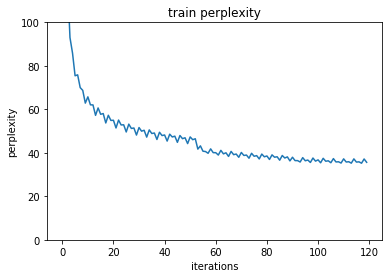

In [0]:
plt.plot(ppl_list)
plt.ylim((0, 100))
plt.xlabel('iterations')
plt.ylabel('perplexity')
plt.title('train perplexity')
plt.show()

### テストデータで評価

In [0]:
ppl = eval_perplexity(model, test_iter)
print(f'| test perplexity {ppl:.2f} |')

| test perplexity 45.45 |


## 文章生成

In [0]:
def text_generate(model, start_ids, length=100, skip_ids=None,
                  prob=True, top=None, seed=2020):
  word_ids = []
  word_ids += start_ids

  random.seed(seed)
  model.eval()
  with torch.no_grad():
    hidden = None
    input_id = start_ids
    while len(word_ids) < length:
      input = torch.tensor(input_id, dtype=torch.long,
                           device=device).view(1, -1).t().contiguous()
      output, hidden = model(input, hidden)
      
      p_list = F.softmax(output[-1].flatten(), dim=0)

      if top is not None:
        sorted_p_list = p_list.sort(descending=True).values[:top]
        sorted_idx = p_list.sort(descending=True).indices[:top]
        p_list = sorted_p_list / sorted_p_list.sum()

      if prob:
        while True:
          rnd = random.random()
          p_sum = 0
          for idx, p in enumerate(p_list):
            p_sum += p.item()
            if rnd < p_sum:
              sampled = idx if top is None else sorted_idx[idx].item()
              break
          if (skip_ids is None) or (sampled not in skip_ids):
            break
      else:
        if skip_ids is not None:
          p_list[skip_ids] = 0
          sampled = p_list.argmax().item()

      word_ids.append(sampled)
      input_id = sampled
    
  return word_ids


save_path = './data/model/weights.pth'
model = MyLSTM(vocab_size, emb_dim, hidden_size, dropout, weight_tied=True)
model.load_state_dict(torch.load(save_path))
model.to(device)

start_words = ['私', 'は']

start_ids = []
for start_word in start_words:
  if start_word not in word_to_id:
    raise KeyError(start_word + ' is not in the dictionary!')
  start_ids.append(word_to_id[start_word])
skip_ids = [word_to_id['<unk>']]

word_ids = text_generate(model, start_ids, length=173,
                         skip_ids=skip_ids, top=None, seed=1)
text = ''.join([id_to_word[w_id] for w_id in word_ids])
text = text.replace('。', '。\n').replace('。\n」', '。」\n')
print(text)

私は、大みそかもお手伝いしたばかりの、いくらだのと信じて離れたいのに、やっぱり、――」「小んです」「え、こんどはそうです。」
「そんなら。」
こんどは、黙ってつとめているのである。
「小説を知ることはあるまい。」
「だと思ってるよ。」
思いめくって、そうして私には、「世相かインバータ」という形が、唯一の返事をしているつもりであるが、私はこのごろその後も疑ってしまったのに、説教をしたように、黙っていた。
私は、頭が親のみちるを感じた。
「だから、それでも、もう五時、きょうは買いましたが、僕たちが下宿にハイリスクですから、
